## Final Step

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from rfpimp import * 

In [2]:
def evaluate(X, y, n_estimators=50):
    rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 is {oob:.5f} using {n:,d} tree nodes with {h} median tree depth")
    return rf, oob

In [3]:
def showimp(rf, X, y):
    features = list(X.columns)
    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')

### Recap

Recall that in the last notebook we did the following:
- converted all 'string' features to ordered categorical features;
- label encoded all these features using the value of 0 to represent missing data;
- fixed some remaining problems with `YearMade` and `MachineHoursCurrentMeter`; and 
- replaced missing numeric data by:
    - adding a new boolean (`True` or `False`) feature to say whether or not that value was missing; 
    - replace missing values in the original feature with the median of all values for that feature.

### Next Steps

In our final work on this data we will:
- Break up the `saledate` feature into its components: year, month, day, etc.;
- Ordinal encode `ProductSize`;
- One hot encode `Hydraulics_Flow` and `Enclosure`; and, 
- Take the logarithm of our target variable, `SalePrice`.

### Create a New, More Stable Baseline

To get a more stable baseline, which will be better to compare improvements in our model, we will use 150 decision tress in the random forest instead of the 50 used previously. With more trees, the variance in the OOB $R^2$ is reduced. That means, if we run the model many times the OOB $R^2$ won't change as much (due to randomness of random forest construction). This will give us more confidence that any improvement we see is due to the changes we have made to the data as opposed to just random variations. 

In [4]:
df_raw = pd.read_feather("bulldozer-train.feather")
df_raw = df_raw.iloc[-100000:]
df = pd.read_feather("bulldozer-train-clean.feather")

In [5]:
X  = df.drop(['SalePrice','saledate'], axis=1) 
y = df['SalePrice']

rf, oob_all = evaluate(X, y, n_estimators=150)

OOB R^2 is 0.90305 using 15,454,084 tree nodes with 43.0 median tree depth


Notice how the OOB score for our new baseline is slightly higher than what we achieved in the last notebook. This is due to the increased number of trees in the random forest model, since the accuracy tends to increase (up to a point) when more trees are used. 

Let's also recall the feature importances for this model as our next steps are based on exploring what more we can do with the most important features to see if we can improve our OOB score. 

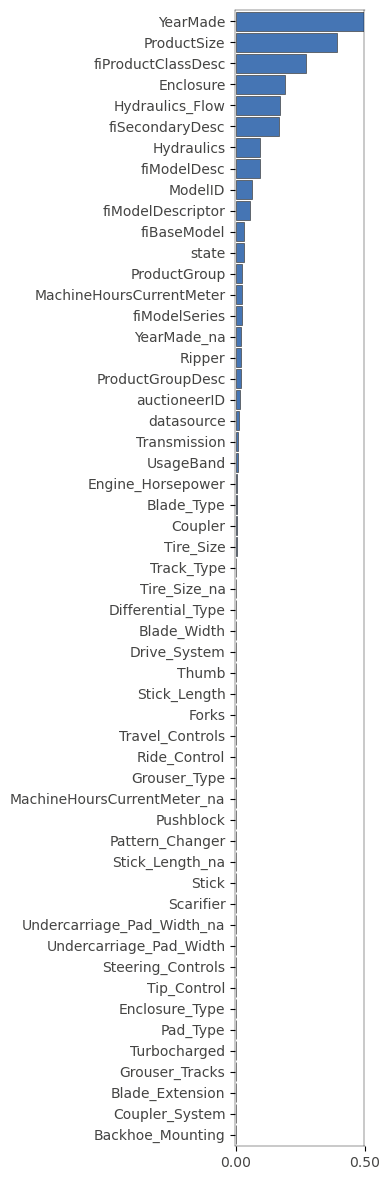

In [6]:
showimp(rf, X, y)

### Creating New Features from `saledate`

We will now deal with the only `datetime` data type we have in our data: `saledate`. For this procedure we will use Pandas's built-in functionality for datetimes. After extracting the date components, we will convert the original `saledate` feature to an integer, which for most operating systems means the number of seconds since 1 January 1970. 

In [9]:
def df_split_dates(df,colname):
    df["saleyear"] = df[colname].dt.year
    df["salemonth"] = df[colname].dt.month
    df["saleday"] = df[colname].dt.day
    df["saledayofweek"] = df[colname].dt.dayofweek
    df["saledayofyear"] = df[colname].dt.dayofyear
    df[colname] = df[colname].astype(np.int64)

In [10]:
df_split_dates(df,'saledate')

In [12]:
df.head(n=10)

,SalePrice,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,...,Tire_Size_na,Stick_Length_na,Undercarriage_Pad_Width_na,YearMade_na,MachineHoursCurrentMeter_na,saleyear,salemonth,saleday,saledayofweek,saledayofyear
0,8300,4663,136,31,1985.0,3496.0,0,1232668800000000000,654,211,...,True,True,True,False,True,2009,1,23,4,23
1,15500,11859,132,25,1995.0,3496.0,0,1232668800000000000,3081,1127,...,True,True,True,False,True,2009,1,23,4,23
2,26000,1133,136,25,1997.0,3496.0,0,1232668800000000000,403,143,...,True,True,True,False,True,2009,1,23,4,23
3,80000,457,136,25,1993.0,3496.0,0,1232668800000000000,2792,998,...,True,True,False,False,True,2009,1,23,4,23
4,77500,3858,136,25,2000.0,3496.0,0,1232668800000000000,1365,413,...,False,True,True,False,True,2009,1,23,4,23
5,17750,4584,136,13,1999.0,3496.0,0,1232668800000000000,277,97,...,True,True,True,False,True,2009,1,23,4,23
6,49000,2249,132,25,2005.0,3496.0,0,1232668800000000000,2749,989,...,True,True,False,False,True,2009,1,23,4,23
7,14000,3409,136,25,2005.0,3496.0,0,1232668800000000000,246,84,...,True,True,True,False,True,2009,1,23,4,23
8,53000,2140,132,25,2005.0,3496.0,0,1232668800000000000,3100,1131,...,True,True,True,False,True,2009,1,23,4,23
9,16750,2758,136,13,1998.0,3496.0,0,1232668800000000000,1685,530,...,True,True,True,False,True,2009,1,23,4,23


In [13]:
df['age'] = df['saleyear'] - df['YearMade']

In [14]:
X  = df.drop(['SalePrice'], axis=1) 
y = df['SalePrice']

rf, oob_all = evaluate(X, y, n_estimators=150)

OOB R^2 is 0.91299 using 14,896,110 tree nodes with 43.0 median tree depth


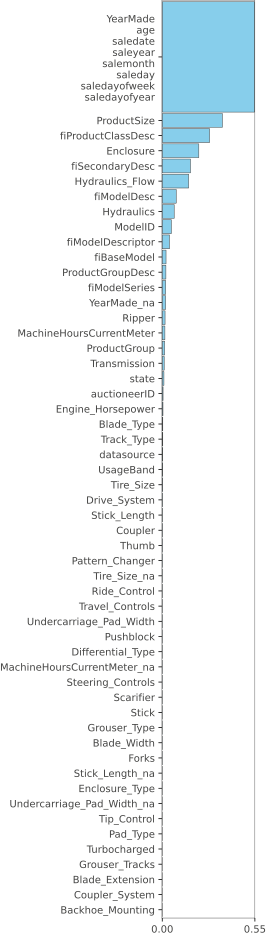

In [20]:
features = list(df.drop(['SalePrice'], axis=1).columns)
datefeatures =list(df.filter(regex=("sale*")).columns)

for f in datefeatures:
    features.remove(f)

features.remove('YearMade')
features.remove('age')

features += [['YearMade','age']+ datefeatures]

I = importances(rf, X, y , features = features)
plot_importances(I, color='skyblue')

### Adjusting the Default Approach

We have said that in practice, or not sure what else to do, we encode categorical features using label encoding, which just assigns an integer to each unique category without considering any order. We want to modify this if we know that the feature is important. In this case, we would use: 
- one hot encoding if the number of unique categories is small, say 10 or less; 
- use ordinal encoding if the feature is ordinal, that is, has a natural ordering. 

We will see examples of both below. 

### Ordinal Encode `ProductSize`

Now let's explore the `ProductSize` feature as it's the second most important according to our model. To see it's connection to our target we will look at the original encoding. 

In [ ]:
temp = df_raw.fillna('nan') 
temp = temp.groupby('ProductSize').mean()
temp[['SalePrice']].sort_values('SalePrice').plot.barh()

The barplot shows that there is a relationship between `ProductSize` and `SalePrice`. This tells us that we should use an ordinal encoding for this feature instead of the label encoding we did before (just assigns an integer to each category value but doesn't respect the ordering). 

In [26]:
df_raw['ProductSize'].unique()

array([None, 'Small', 'Large / Medium', 'Medium', 'Compact', 'Mini',
       'Large'], dtype=object)

In [22]:
sizes = {None:0, 'Mini':1, 'Compact':1, 'Small':2, 'Medium':3, 'Large / Medium':4, 'Large':5}

df['ProductSize'] = df_raw['ProductSize'].map(sizes).values
df['ProductSize'].unique()

array([0, 2, 4, 3, 1, 5], dtype=int64)

In [23]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

rf, oob_psize = evaluate(X, y, n_estimators=150)

OOB R^2 is 0.91536 using 14,872,978 tree nodes with 45.0 median tree depth


This gives us another increase, although small. 

### One Hot Encoding

We will skip over the next most important feature, `fiProductClassDesc` (see [Section 8.5](https://mlbook.explained.ai/bulldozer-feateng.html#sec:8.5) for details on that feature), and consider `Enclosure` and `Hydraulics_Flow`.   

We will use one-hot encoding on these features. This technique was outlined in the notebook **Part 1 - Categorical Variables**, so review the appropriate section there if you forget. 

Again, we will need to go back to the original data do this, as the cleaned data has already label encoded these features. Let's first verify that they are not ordinal and don't contain too many unique values. 

In [24]:
df_raw['Enclosure'].unique()

array(['OROPS', 'EROPS', 'EROPS w AC', None, 'EROPS AC', 'NO ROPS'],
      dtype=object)

In [25]:
df_raw['Hydraulics_Flow'].unique()

array([None, 'Standard', 'High Flow', 'None or Unspecified'], dtype=object)

In [27]:
df['Hydraulics_Flow'].unique()

array([0, 2, 1], dtype=int8)

It looks like both features fit the criteria for one-hot encoding (although an argument could be made that `Hydraulics_Flow` may be ordinal, given the uncertainty we will assume it is not). Notice also that since we are using the original data we will need to normalize the representations of missing values before we do our encoding.  

#### `Hydraulics_Flow`

To handle this feature we will:
- replace our label encoded version of this feature with the original values;
- normalize the representation of mising values to `np.nan`; and, 
- create a dataframe of the one-hot encoded feature;
- delete the original feature; 
- combine our cleaned data with the one-hot encoded dataframe. 

Note that missing values will be indicated by all `False` (or 0) values when one-hot encoded. 

In [28]:
df['Hydraulics_Flow'] = df_raw['Hydraulics_Flow'].values
df['Hydraulics_Flow'] = df['Hydraulics_Flow'].replace('None or Unspecified', np.nan)
df['Hydraulics_Flow'].unique()


array([None, 'Standard', 'High Flow', nan], dtype=object)

In [29]:
onehot = pd.get_dummies(df['Hydraulics_Flow'], prefix='Hydraulics_Flow', dtype=bool)
onehot.head(3)

,Hydraulics_Flow_High Flow,Hydraulics_Flow_Standard
0,False,False
1,False,False
2,False,False


In [30]:
del df['Hydraulics_Flow']

df = pd.concat([df, onehot], axis=1)

In [31]:
df.head(3).T

,0,1,2
SalePrice,8300,15500,26000
ModelID,4663,11859,1133
datasource,136,132,136
auctioneerID,31,25,25
YearMade,1985.0,1995.0,1997.0
...,...,...,...
saledayofweek,4,4,4
saledayofyear,23,23,23
age,24.0,14.0,12.0
Hydraulics_Flow_High Flow,False,False,False


#### `Enclosure`

To handle this feature we will:
- replace our label encoded version of this feature with the original values;
- clean up the data as two of the category values represent the same category;
- normalize the representation of mising values to `np.nan`; and, 
- create a dataframe of the one-hot encoded feature;
- delete the original feature; 
- combine our cleaned data with the one-hot encoded dataframe. 

Note that missing values will be indicated by all `False` (or 0) values when one-hot encoded. 

In [32]:
df_raw['Enclosure'].unique()

array(['OROPS', 'EROPS', 'EROPS w AC', None, 'EROPS AC', 'NO ROPS'],
      dtype=object)

In [33]:
df['Enclosure'] = df_raw['Enclosure'].values
df['Enclosure'] = df['Enclosure'].replace('EROPS w AC', 'EROPS AC')
#df['Enclosure'] = df['Enclosure'].replace('None or Unspecified', np.nan)

onehot = pd.get_dummies(df['Enclosure'], prefix='Enclosure', dtype=bool)
onehot.head(3)

,Enclosure_EROPS,Enclosure_EROPS AC,Enclosure_NO ROPS,Enclosure_OROPS
0,False,False,False,True
1,True,False,False,False
2,True,False,False,False


In [34]:
del df['Enclosure']
df = pd.concat([df, onehot], axis=1)
df.head(3).T

,0,1,2
SalePrice,8300,15500,26000
ModelID,4663,11859,1133
datasource,136,132,136
auctioneerID,31,25,25
YearMade,1985.0,1995.0,1997.0
...,...,...,...
Hydraulics_Flow_Standard,False,False,False
Enclosure_EROPS,False,True,True
Enclosure_EROPS AC,False,False,False
Enclosure_NO ROPS,False,False,False


Let's train a model and see if this has had any impact on performance.

In [36]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

rf, oob_one_hot = evaluate(X, y, n_estimators=150)

OOB R^2 is 0.91375 using 14,896,950 tree nodes with 43.0 median tree depth


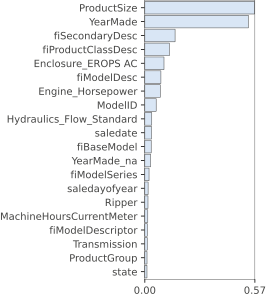

In [37]:
I = importances(rf, X, y)
plot_importances(I.head(20))

### Using `log(SalePrice)`

The last thing we will try is to train our model on the logarithm of the price instead of just the price. 

<Axes: >

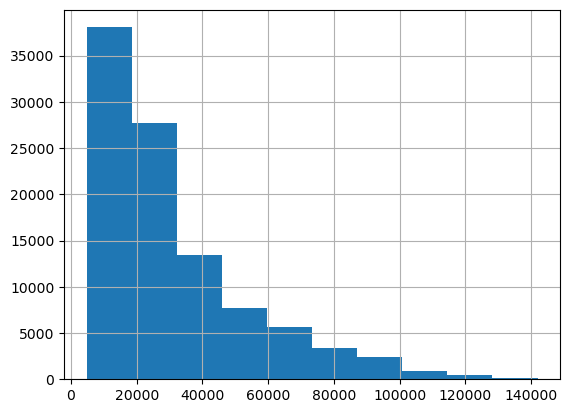

In [38]:
df['SalePrice'].hist()

<Axes: >

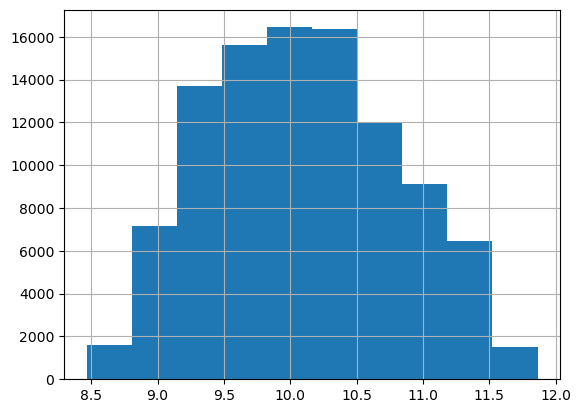

In [39]:
np.log(df['SalePrice']).hist()

In [40]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
log_y = np.log(y)

rf, oob_log = evaluate(X, log_y, n_estimators=150)

OOB R^2 is 0.91886 using 15,651,216 tree nodes with 44.0 median tree depth


### Summary

So, to recap what we have done, we:
- broke up the `saledate` feature into its components: year, month, day, etc.;
- added an `age` feature; 
- ordinal encoded `ProductSize`;
- one-hot encoded `Hydraulics_Flow` and `Enclosure`; and, 
- used the logarithm of `SalePrice` as our new target variable.

### Results

After all the techniques we have used in this notebook, we have increased our OOB $R^2$ score from the more stable baseline of 0.903 to 0.919, which is a nice increase. This represents an increase in the explained variance of

In [41]:
print(f"{round(100 * ((1 - 0.903) - (1 - 0.919)) / (1 - 0.903))}%")

16%
